In [1]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [2]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [3]:
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

In [4]:
key = jax.random.PRNGKey(123)

# single layer

In [5]:
f = ProbitLinear(
    3,
    1,
    key,
    A=RandomOrthogonalProjection(4.0),
    b=RandomOrthogonalProjection(0.0),
    C=RandomOrthogonalProjection(1.0),
    d=RandomOrthogonalProjection(1.0),
)
network = ProbitLinearNetwork(f)

In [6]:
x = 1 + jnp.zeros(f.in_size)
Σ = jnp.eye(x.shape[0]) * 1

In [7]:
mean, cov = f._mc_mean_cov(x, Σ, key, 1_000_000)
mean, cov

(Array([0.35777946], dtype=float64), Array(1.82030324, dtype=float64))

In [8]:
print("ekf mean", f._propagate_mean_lin(x, Σ))
print("analytic mean", f._propagate_mean(x, Σ))
print("monte carlo mean", mean)

ekf mean [0.9472811]
analytic mean [0.35838089]
monte carlo mean [0.35777946]


In [9]:
np.linalg.eigvalsh(f._propagate_cov(x, Σ))

array([1.82144508])

In [10]:
print("ekf cov", f._propagate_cov_lin(x, Σ))
print("analytic cov", f._propagate_cov(x, Σ))
print("monte carlo covariance", cov)

ekf cov [[1.89707227]]
analytic cov [[1.82144508]]
monte carlo covariance 1.8203032447590575


# Small-variance test

In [16]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 1
output_size = 1
hidden_size = 10
network = ProbitLinearNetwork(
    ProbitLinear(
        input_size,
        output_size,
        key1,
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size) * 1e-4

In [17]:
mean, cov = network[0]._mc_mean_cov(μ, Σ, key=jax.random.PRNGKey(1), rep=1_000_000)
mean, cov

(Array([0.68265668], dtype=float64), Array(2.34858974e-05, dtype=float64))

In [18]:
mean, cov = network.propagate_mean_cov(μ, Σ, method="analytic")
mean, cov

(Array([0.6826653], dtype=float64), Array([[2.34211033e-05]], dtype=float64))

In [19]:
mean, cov = network.propagate_mean_cov(μ, Σ, method="linear")
mean, cov

(Array([0.68268949], dtype=float64), Array([[2.34199326e-05]], dtype=float64))

In [20]:
mean, cov = network.propagate_mean_cov(μ, Σ, method="unscented")
mean, cov

(Array([0.68242332], dtype=float64), Array([[0.00025776]], dtype=float64))

# Deep MLP

In [21]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 2
output_size = 1
hidden_size = 70
layers = [
    ProbitLinear(
        input_size,
        hidden_size,
        key1,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key2,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key3,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        output_size,
        key4,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
]

In [22]:
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size)

In [23]:
network = ProbitLinearNetwork(*layers)

In [24]:
def plot_mc(ax, μ, Σ):
    μ_unscented, Σ_unscented = network.propagate_mean_cov(μ, Σ, method="unscented")
    μ_lin, Σ_lin = network.propagate_mean_cov(μ, Σ, method="linear")
    μ_adf, Σ_adf = network.propagate_mean_cov(μ, Σ, method="analytic")

    input_samples = scipy.stats.qmc.MultivariateNormalQMC(mean=μ, cov=Σ, rng=42).random(
        2**20
    )
    output_samples = jax.vmap(network)(input_samples)
    y_mesh = np.linspace(np.min(output_samples), np.max(output_samples), 2000)

    ax.plot(
        y_mesh,
        scipy.stats.gaussian_kde(output_samples.reshape(-1))(y_mesh),
        label="empirical KDE",
    )
    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=output_samples.mean(), scale=output_samples.std()
        ),
        label="pseudo-true Gaussian fit",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_unscented.reshape(-1), scale=Σ_unscented.reshape(-1) ** 0.5
        ),
        label="unscented approximation",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_lin.reshape(-1), scale=Σ_lin.reshape(-1) ** 0.5
        ),
        label="linear approximation",
        linestyle="--",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_adf.reshape(-1), scale=Σ_adf.reshape(-1) ** 0.5
        ),
        label="my approximation",
        linestyle="--",
    )
    ax.legend()

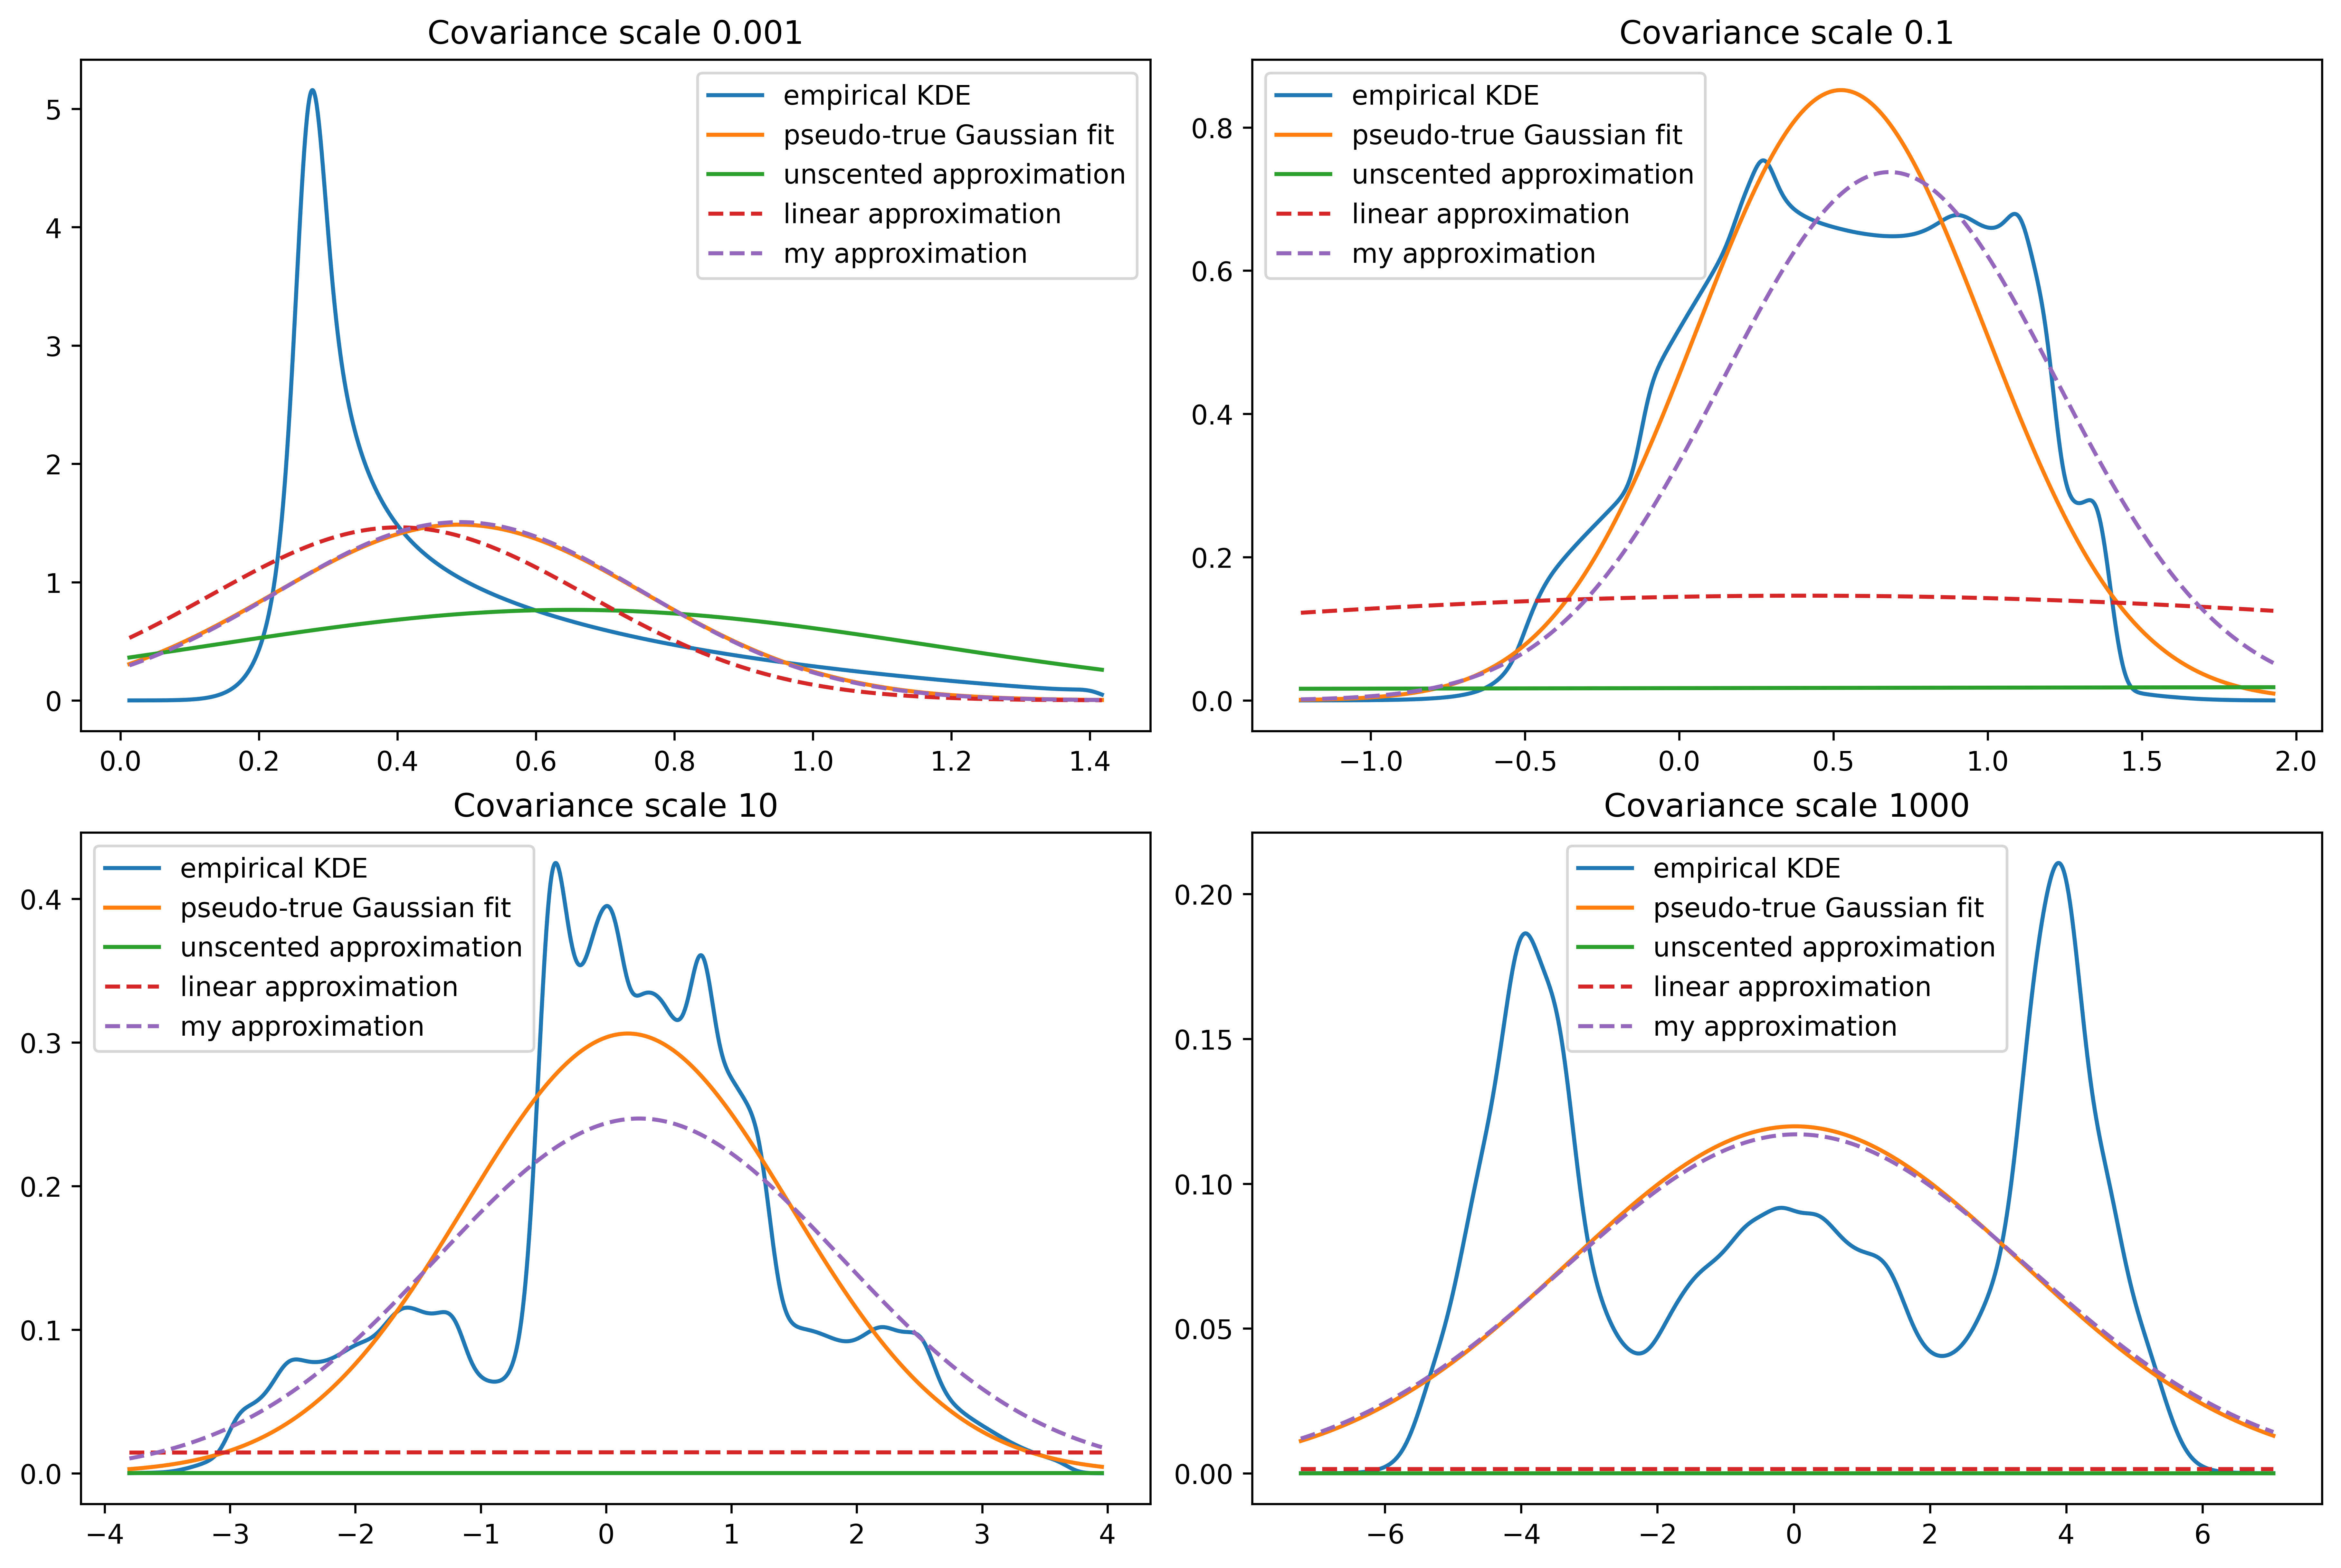

In [26]:
fig = Figure(figsize=(12, 8), dpi=600, constrained_layout=1)
ax = fig.add_subplot(221)
ax.set_title("Covariance scale 0.001")
plot_mc(ax, μ, Σ * 1e-3)
ax = fig.add_subplot(222)
ax.set_title("Covariance scale 0.1")
plot_mc(ax, μ, Σ * 1e-1)
ax = fig.add_subplot(223)
ax.set_title("Covariance scale 10")
plot_mc(ax, μ, Σ * 1e1)
ax = fig.add_subplot(224)
ax.set_title("Covariance scale 1000")
plot_mc(ax, μ, Σ * 1e3)

fig